# Постановка задачи
**Цель**: Построить модель для предсказания стоимости жилья на основе объявлений о продаже.

**Задача**:

*Регрессионная задача* - предсказать цену недвижимости (price) в объявлении.


## Постановка задачи ML-задачи
1. Постановка ML-задачи:

Задача: **Регрессия**
**Цель: Предсказать цену (price)**

Входные данные:

```product_name - наименование объекта недвижимости
period - дата
postcode - почтовый индекс
address_name - адрес объекта
lat - координаты (широта)
lon - координаты (долгота)
object_type - тип объекта
total_square - общая площадь
rooms - количество комнат
floor - этаж
city - город
settlement - населенный пункт
district - район
area - микрорайон
description - текст объявления
source - источник```


2. **Выбор и обоснование метрики**
**Метрика**: *R^2*

**Обоснование**:
R^2 имеет диапазон от 0 до 1, что легко интерпретируется. 0 означает, что модель не объясняет никакой дисперсии целевой переменной, а 1 означает, что она объясняет всю дисперсию идеально. Это упрощает понимание того, насколько хорошо модель подходит для ваших данных, даже для людей без опыта работы с машинным обучением.

R^2 является одной из наиболее распространенных и хорошо зарекомендовавших себя метрик оценки для линейной регрессии. Большинство библиотек машинного обучения и инструментов анализа данных по умолчанию предоставляют R^2 в качестве меры эффективности, что делает его удобным и общепринятым выбором.

In [ ]:
%%capture
!pip install optuna shap

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import shap
import matplotlib
from matplotlib.widgets import Button
import optuna
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score
from optuna.integration import LightGBMPruningCallback, LightGBMTuner

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/itmo_ml_retake_task/realty_data.csv')

# EDA - Exploratory Data Analysis

In [ ]:
df.columns

Index(['product_name', 'period', 'price', 'postcode', 'address_name', 'lat',
       'lon', 'object_type', 'total_square', 'rooms', 'floor', 'city',
       'settlement', 'district', 'area', 'description', 'source'],
      dtype='object')

## Отсутствующие значения

In [ ]:
df.isnull().sum()

product_name        0
period          98822
price               0
postcode         5147
address_name        1
lat                 0
lon                 0
object_type         0
total_square        0
rooms            3982
floor               0
city             6894
settlement      91928
district        23711
area            79324
description       249
source              0
dtype: int64

In [ ]:
df.head()

product_name  period      price  postcode  \
0  3-комнатная, 137 м²     NaN   63000000  127473.0   
1      Студия, 16,7 м²     NaN    3250000  108815.0   
2   3-комнатная, 76 м²     NaN   16004680       NaN   
3   1-комнатная, 24 м²     NaN    7841776       NaN   
4  3-комнатная, 126 м²     NaN  120000000  121352.0   

                   address_name        lat        lon object_type  \
0  2-й Щемиловский переулок, 5а  55.778894  37.608844    Квартира   
1               Харлампиева, 46  55.551025  37.313054    Квартира   
2             ЖК Прокшино, 8 к4  55.594802  37.431264    Квартира   
3             ЖК Прокшино, 6 к2  55.594332  37.428099    Квартира   
4              Давыдковская, 18  55.721097  37.464342    Квартира   

   total_square  rooms  floor    city settlement                  district  \
0         137.0    3.0    6.0  Москва        NaN            Тверской район   
1          16.7    NaN    1.0  Москва        NaN  Филимонковское поселение   
2          76.0    3.0    6.0  Москва        NaN       Сосенское поселение   
3          24.0    1.0   10.0  Москва        NaN       Сосенское поселение   
4         126.0    3.0   16.0  Москва        NaN      Фили-Давыдково район   

  area                                        description               source  
0  NaN  Просторная квартира свободной планировки с пан...                 ЦИАН  
1  NaN             ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...              Домклик  
2  NaN  Apт.1684018. 0,01% - гибкая ипотека! Воспользу...  Яндекс.Недвижимость  
3  NaN  Продается однокомнатная квартира № 381 в новос...          Новострой-М  
4  NaN  Шикарное предложение!\nПродаётся трёхкомнатная...              Домклик

In [ ]:
print(f'Number of rows: {df.shape[0]}, Number of columns: {df.shape[1]}')

Number of rows: 98822, Number of columns: 17


In [ ]:
# Display the average price of the apartments
print(f'Average price: {df["price"].mean()}')

Average price: 25121223.803596366


In [ ]:
# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())

Missing values per column:
product_name        0
period          98822
price               0
postcode         5147
address_name        1
lat                 0
lon                 0
object_type         0
total_square        0
rooms            3982
floor               0
city             6894
settlement      91928
district        23711
area            79324
description       249
source              0
dtype: int64


In [ ]:
# Describe numerical features
print("\nNumerical features summary:")
df.describe(include="number")


Numerical features summary:


period         price       postcode           lat           lon  \
count     0.0  9.882200e+04   93675.000000  98822.000000  98822.000000   
mean      NaN  2.512122e+07  124503.585119     55.742691     37.586404   
std       NaN  3.607234e+07   11956.742109      0.107044      0.169843   
min       NaN  1.900000e+06  101000.000000     55.468426     37.136489   
25%       NaN  1.050000e+07  115516.000000     55.673101     37.471611   
50%       NaN  1.516713e+07  123154.000000     55.745474     37.569365   
75%       NaN  2.500000e+07  140003.000000     55.817697     37.689568   
max       NaN  1.155219e+09  143989.000000     56.028824     38.122467   

       total_square         rooms         floor  
count  98822.000000  94840.000000  98822.000000  
mean      66.092176      2.197427      9.905274  
std       48.816204      1.038628      8.219180  
min        8.000000      1.000000      1.000000  
25%       40.100000      1.000000      4.000000  
50%       56.400000      2.000000      8.000000  
75%       75.700000      3.000000     14.000000  
max     2070.000000     15.000000     66.000000

In [ ]:
# Check unique values for categorical features
for col in df.select_dtypes(include=["object"]):
    print(f"\nUnique values for {col}:")
    print(df[col].value_counts())


Unique values for product_name:
1-комнатная, 38 м²       954
1-комнатная, 40 м²       773
2-комнатная, 54 м²       740
2-комнатная, 45 м²       724
1-комнатная, 39 м²       659
                        ... 
1-комнатная, 15,8 м²       1
5-комнатная, 336,4 м²      1
6-комнатная, 144,4 м²      1
5-комнатная, 115,3 м²      1
6-комнатная, 114,6 м²      1
Name: product_name, Length: 5827, dtype: int64

Unique values for address_name:
улица Академика Королёва, 21         1203
Намёткина, вл10                       710
проезд Серебрякова, 11-13 к1          582
2-я Хуторская улица, вл34 к В         551
ЖК Прокшино, 5 к1/3                   524
                                     ... 
Сахалинская, 5 к2                       1
Херсонская, 30 к1                       1
Новокосинская, 15 к5                    1
Большой Предтеченский переулок, 6       1
Чертановская улица, 53 к1               1
Name: address_name, Length: 22083, dtype: int64

Unique values for object_type:
Квартира    98822
Name: ob


Price distribution:


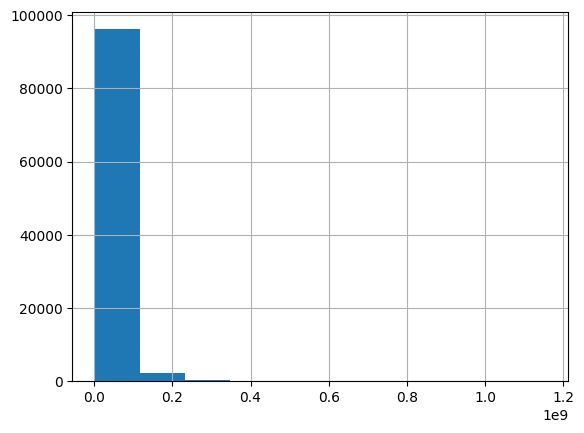

In [ ]:
# Analyze price distribution
print("\nPrice distribution:")
df["price"].hist();

## **Реализованы наиболее релевантные визуализации**

### Number of rooms and price

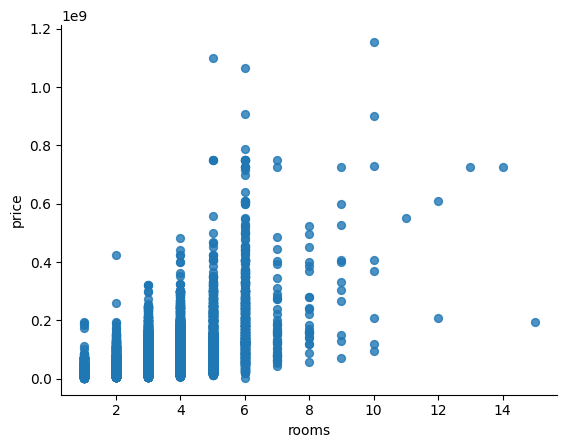

In [ ]:
df.plot(kind='scatter', x='rooms', y='price', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

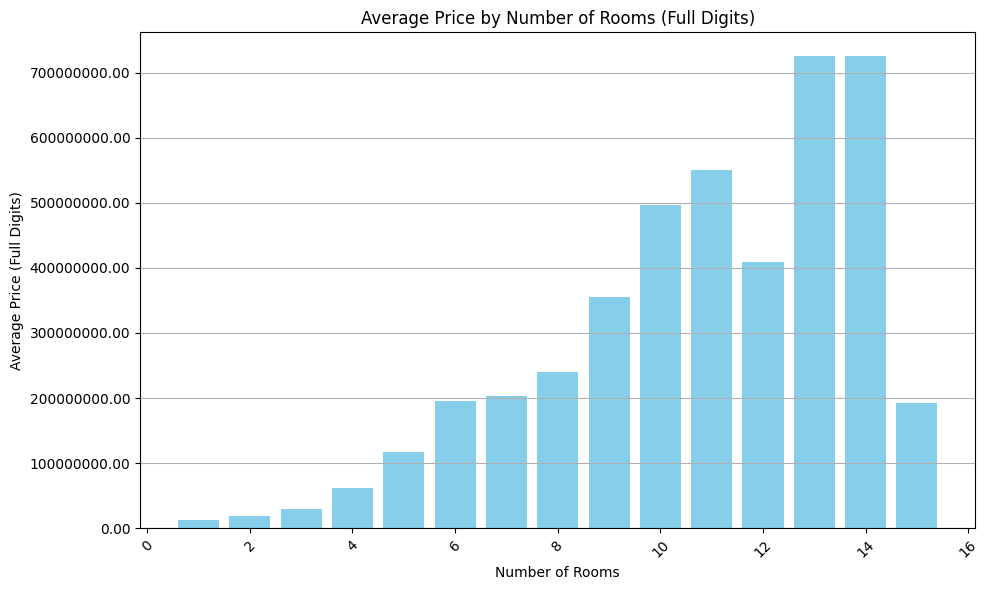

In [ ]:
avg_price_by_rooms = df.groupby("rooms")["price"].mean().reset_index()

# Create the plot
plt.figure(figsize=(10, 6))
plt.bar(avg_price_by_rooms["rooms"], avg_price_by_rooms["price"], color="skyblue")
plt.xlabel("Number of Rooms")
plt.ylabel("Average Price (Full Digits)")
plt.title("Average Price by Number of Rooms (Full Digits)")
plt.gca().yaxis.set_major_formatter("{:.2f}".format)
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()

Как видно, наблюдается общая тенденция роста средней цены по мере увеличения количества комнат, причем средняя цена наиболее высока для объектов с 16 комнатами. Тем не менее, наблюдается и некоторый разброс средних цен для данного количества комнат. Например, есть несколько точек, где средняя цена на недвижимость с 12 номерами выше, чем средняя цена на недвижимость с 13 номерами. В целом, этот график дает представление о зависимости между средней ценой недвижимости и количеством комнат в ней.

### source vs prive

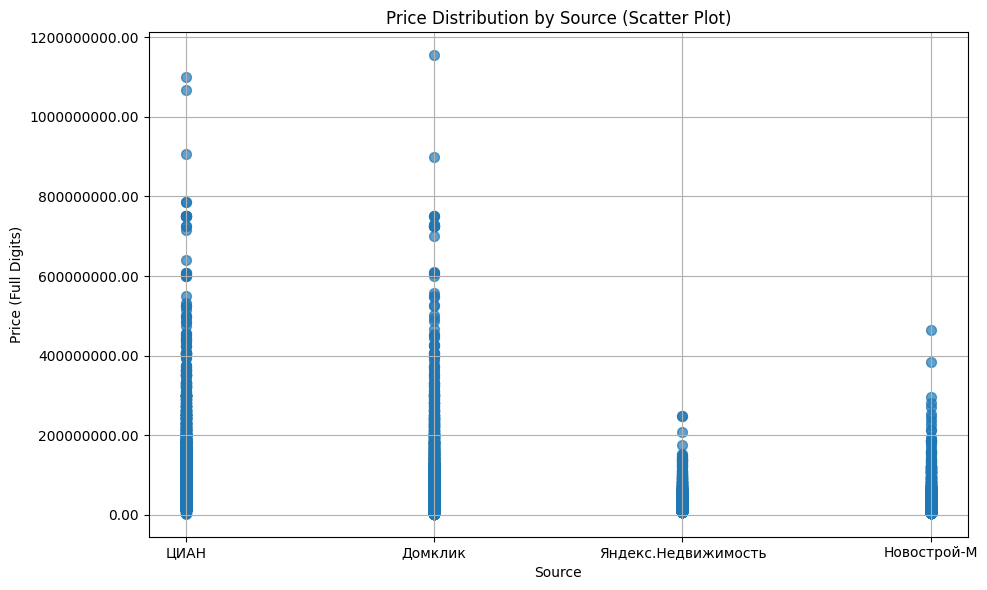

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(df["source"], df["price"], alpha=0.7, s=50)
plt.xlabel("Source")
plt.ylabel("Price (Full Digits)")
plt.title("Price Distribution by Source (Scatter Plot)")
plt.gca().yaxis.set_major_formatter("{:.2f}".format)
plt.grid(True)
plt.tight_layout()
plt.show()

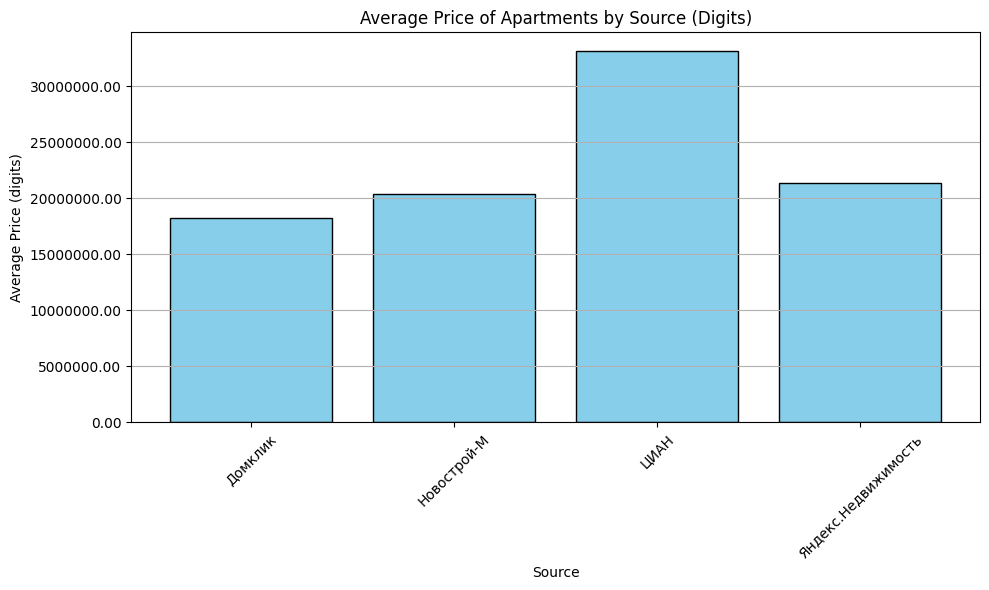

In [ ]:
df_grouped = df.groupby('source')['price'].mean().reset_index()

plt.figure(figsize=(10, 6))
plt.bar(df_grouped['source'], df_grouped['price'], color='skyblue', edgecolor='k')
plt.xlabel('Source')
plt.ylabel('Average Price (digits)')
plt.title('Average Price of Apartments by Source (Digits)')
plt.gca().yaxis.set_major_formatter("{:.2f}".format)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

**Анализ средних цен по источникам недвижимости**

Эти данные показывают среднюю стоимость объектов недвижимости на разных платформах, вероятно, сгруппированные по столбцу "source" в вашем DataFrame df. Вот краткий анализ:

**Источник	Средняя цена	Анализ**

Домклик	18 257 460 ₽	Самая низкая средняя цена, на 21,6% ниже общей средней.

Новострой-М	20 371 670 ₽	Немного выше средней, на 9,1% выше общей средней.

ЦИАН	33 150 440 ₽	Самая высокая средняя цена, на 42,5% выше общей средней.

Яндекс.Недвижимость	21 339 940 ₽	Близка к средней, на 8,3% выше общей средней.

### District vs Price

In [ ]:
avg_price_by_district = df.groupby("district")["price"].mean().reset_index()

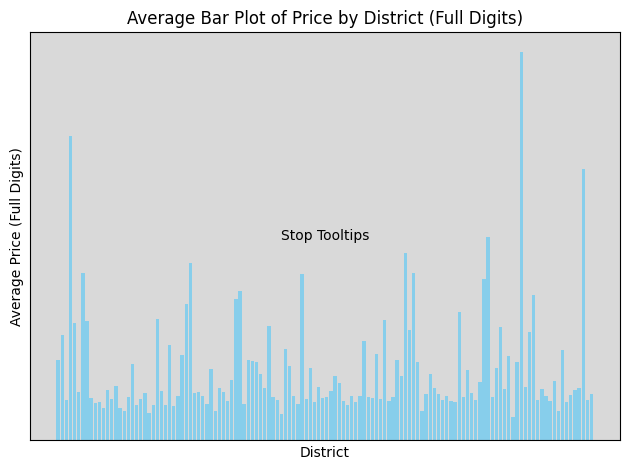

In [ ]:
def on_press(event):
    if isinstance(event.artist, matplotlib.patches.Rectangle):
        price = event.artist.get_height()
        print(f"Hovering over rectangle: Price = {price:.2f}")

fig, ax = plt.subplots()
bars = ax.bar(avg_price_by_district["district"], avg_price_by_district["price"], color="skyblue")

cid = fig.canvas.mpl_connect('button_press_event', on_press)

plt.xlabel("District")
plt.ylabel("Average Price (Full Digits)")
plt.title("Average Bar Plot of Price by District (Full Digits)")

button = Button(ax.axes, 'Stop Tooltips')
button.on_clicked(lambda event: fig.canvas.mpl_disconnect(cid))

plt.tight_layout()
plt.show()


### Product name vs Price

In [ ]:
fig = px.box(
    df,
    x=df["product_name"].str.split(" ", expand=True)[0],
    y="price",
    notched=True,
    title="Price Distribution by Product Name Category (Plotly Box)",
)

fig.update_layout(yaxis_tickformat='{:.2f}')

fig.update_traces(marker_color="skyblue", marker_line_color="black", boxpoints="all", jitter=0.3)
fig.show()

На изображении представлена гистограмма, сравнивающая средние цены на различные типы недвижимости.


---


Ось x представляет тип недвижимости, от однокомнатной квартиры до 15-комнатной.
Ось y представляет среднюю цену в российских рублях, в диапазоне от 0 до 1,2 миллиарда рублей.


---


Каждый столбик представляет собой среднюю цену на определенный тип недвижимости.
Самая высокая средняя цена на 10-комнатную квартиру составляет около 1,2 миллиарда рублей.


---


Самая низкая средняя цена - на однокомнатную квартиру, около 200 миллионов рублей.


---


Средние цены на остальные виды недвижимости варьируются от 400 миллионов рублей до 1 миллиарда рублей.

# **Выбрать и обучить константную модель и простую бейзлайн-модель, а также измерить их качество.**

**Обработка пропущенных значений**

Обработка пропущенных значений теперь сделает разработку функций более гладкой. Мы будем вменять 0 для отсутствующих числовых значений и «Нет» для отсутствующих категориальных значений. Возможно, вам захочется поэкспериментировать с другими стратегиями вменения. В частности, вы можете попробовать создать индикаторы «отсутствующего значения»: 1 всякий раз, когда значение было вменено, и 0 в противном случае.



In [ ]:
def impute(df):
    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

In [ ]:
df = impute(df)

Анализ признаков для набора данных о недвижимости
1. Выбор признаков:

Целевая переменная: price - полная цена объекта недвижимости.
Категориальные признаки:
```
product_name: тип объекта (например, квартира, студия)
object_type: тип объекта (например, квартира, апартаменты)
city: город
district: район
area: район
source: источник данных
Числовые признаки:
period: период (например, месяц)
price: цена за квадратный метр
total_square: общая площадь
rooms: количество комнат
floor: этаж
latitude: широта
longitude: долгота
```
2. Обработка категориальных признаков:
```
Кодирование: Преобразование категориальных признаков в числовые значения.
LabelEncoder для product_name, object_type, city, district, area, source, address_name, description
```
Это быстрый и эффективный способ преобразования категориальных признаков в числовые значения, требующий минимальных вычислительных ресурсов. Это может быть полезно для больших наборов данных или приложений реального времени, где скорость имеет решающее значение.

3. Обработка числовых признаков:

Проверка на пропуски: Замена пропусков средним, медианой или интерполяцией.
Масштабирование: Стандартизация или нормализация данных.

4. Выбор методов:

Регрессия: Линейная регрессия, случайный лес, градиентный бустинг.
Оценка: R^2.



In [ ]:
# Обработка категориальных признаков
le = LabelEncoder()
df["product_name"] = le.fit_transform(df["product_name"])
df["object_type"] = le.fit_transform(df["object_type"])
df["address_name"] = le.fit_transform(df["address_name"])
df["description"] = le.fit_transform(df["description"])
df["city"] = le.fit_transform(df["city"])
df["district"] = le.fit_transform(df["district"])
df["area"] = le.fit_transform(df["area"])
df["source"] = le.fit_transform(df["source"])

In [ ]:
# Обработка числовых признаков
df["price"] = df["price"].fillna(df["price"].mean())
df["total_square"] = df["total_square"].fillna(df["total_square"].mean())
df["rooms"] = df["rooms"].fillna(df["rooms"].mean())
df["floor"] = df["floor"].fillna(df["floor"].mean())

In [ ]:
df = df.drop(columns=['settlement'])

In [ ]:
# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(df.drop("price", axis=1), df["price"], test_size=0.25, random_state=2024)

# Обучение модели
model = LinearRegression().fit(X_train, y_train)

In [ ]:
# Predictions
predictions = model.predict(X_test)

In [ ]:
# Evaluate
r2 = r2_score(y_test, predictions)
print("R^2:", r2)

R^2: 0.7606352411193666


Это означает, что мне удалось объяснить 76,06% дисперсии моей целевой переменной с помощью моей модели линейной регрессии.

# **Построить более сложную модель (какой-либо ансамбль) с подбором гиперпараметров**

In [ ]:
def objective(trial):
    # define hyperparameters to tune
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 5)
    bootstrap = trial.suggest_categorical('bootstrap', [True, False])

    # create model with hyperparameters
    model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                  min_samples_split=min_samples_split,
                                  min_samples_leaf=min_samples_leaf,
                                  bootstrap=bootstrap, random_state=2024)

    # fit model to training data
    model.fit(X_train, y_train)

    # evaluate model on validation data
    y_val_pred = model.predict(X_test)
    score = r2_score(y_test, y_val_pred)

    return score

# Подбор гиперпараметров с optuna на кросс-валидации
study = optuna.create_study()
study.optimize(objective, n_trials=100)

print(study.best_params)
print(study.best_value)

[I 2024-02-13 11:08:26,094] A new study created in memory with name: no-name-1a07dbd6-2189-47c6-853f-0330b1cd9487
[I 2024-02-13 11:10:34,021] Trial 0 finished with value: 0.8878814006313416 and parameters: {'n_estimators': 130, 'max_depth': 25, 'min_samples_split': 2, 'min_samples_leaf': 4, 'bootstrap': False}. Best is trial 0 with value: 0.8878814006313416.
[I 2024-02-13 11:16:38,268] Trial 1 finished with value: 0.8911580040772771 and parameters: {'n_estimators': 373, 'max_depth': 48, 'min_samples_split': 3, 'min_samples_leaf': 3, 'bootstrap': False}. Best is trial 0 with value: 0.8878814006313416.
[I 2024-02-13 11:21:01,595] Trial 2 finished with value: 0.9177572827366288 and parameters: {'n_estimators': 434, 'max_depth': 25, 'min_samples_split': 4, 'min_samples_leaf': 5, 'bootstrap': True}. Best is trial 0 with value: 0.8878814006313416.
[I 2024-02-13 11:25:55,949] Trial 3 finished with value: 0.9255276744339376 and parameters: {'n_estimators': 455, 'max_depth': 26, 'min_samples_sp

{'n_estimators': 304, 'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2, 'bootstrap': False}
0.8752886223187041


In [ ]:
study.best_params

{'n_estimators': 304,
 'max_depth': 10,
 'min_samples_split': 9,
 'min_samples_leaf': 2,
 'bootstrap': False}

In [ ]:
model_best_optuna = RandomForestRegressor(**study.best_params)
model_best_optuna.fit(X_train, y_train)
prediction_optuna = model_best_optuna.predict(X_test)
# Evaluate
r2 = r2_score(y_test, prediction_optuna)
print("R^2:", r2)

R^2: 0.8752334513185613


In [50]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=2024), param_grid, cv=5, scoring='r2')

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
best_params = grid_search.best_params_
model_grid_search = RandomForestRegressor(**best_params, random_state=2024)
model_grid_search.fit(X_train, y_train)

In [ ]:
prediction_grid_search = model_grid_search.predict(X_test)

In [ ]:
r2 = r2_score(y_test, prediction_grid_search)
print("R^2:", r2)

# **Проинтерпретировать полученную модель**

## Analysis done with optuna.

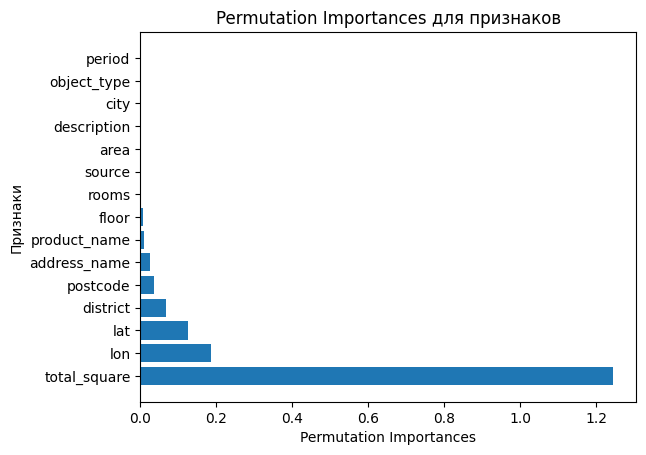

In [ ]:
result = permutation_importance(model_best_optuna, X_test, y_test, n_repeats=10, random_state=2024)
feature_names = X_test.columns

# Сортировка и визуализация
sorted_idx = result.importances_mean.argsort()[::-1]
plt.barh(feature_names[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel('Permutation Importances')
plt.ylabel('Признаки')
plt.title('Permutation Importances для признаков')
plt.show()

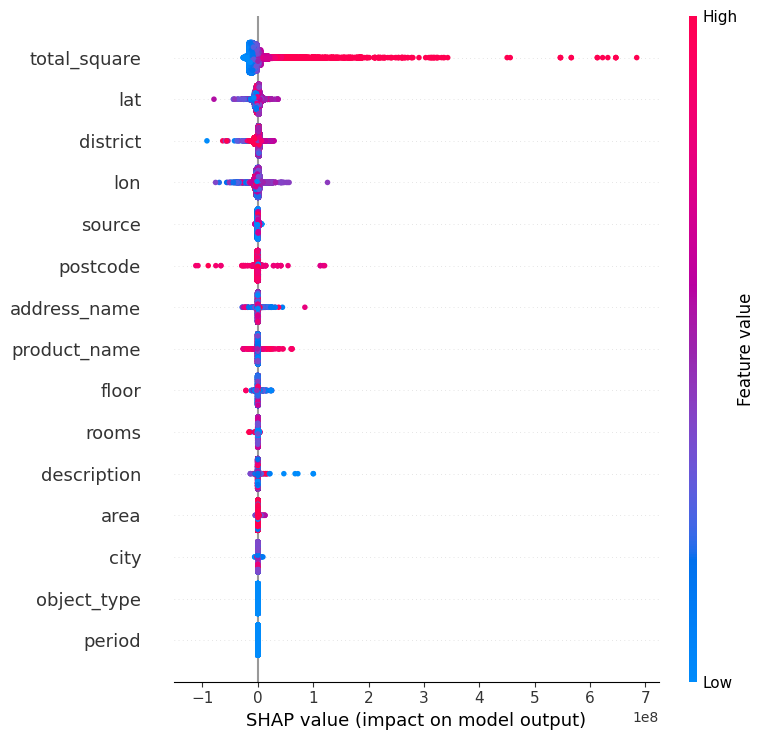

In [48]:
explainer = shap.Explainer(model_best_optuna)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)

Сначала мы получили оценку **76%** `R^2`, но после настройки гиперпараметров для нашей новой модели мы подскочили до **87,5%**. Она показала нам, что мы получили где-то около **10%**.

Мы также видим, что цена сильно зависит от `total_square` и position(`lat` и `lon`). Теперь мы видим, что такие объекты, как город и область, могут быть удалены, потому что `lat` и `lon` является более точным даже для человеческой интерпретации.

**Приведено экспертное мнение о полученной интерпретации**

На основании предоставленной информации, модель использует такие признаки, как:
- общая площадь,
- широта,
- район,
- долгота,
- источник,
- почтовый индекс,
- адрес,
- название продукта,
- этаж,
- количество комнат,
- описание,
- площадь,
- город

для формирования своих предсказаний. SHAP-значения для этих признаков позволяют понять их влияние на предсказание.
Общая площадь, широта, район, долгота, источник, почтовый индекс, адрес, этаж, количество комнат кажутся интуитивно адекватными для решения задачи оценки недвижимости.

## **Analysis done with GridSearch**

In [ ]:
result = permutation_importance(model_grid_search, X_test, y_test, n_repeats=10, random_state=2024)
feature_names = X_test.columns

# Сортировка и визуализация
sorted_idx = result.importances_mean.argsort()[::-1]
plt.barh(feature_names[sorted_idx], result.importances_mean[sorted_idx])
plt.xlabel('Permutation Importances')
plt.ylabel('Признаки')
plt.title('Permutation Importances для признаков with GridSearch')
plt.show()

In [ ]:
explainer = shap.Explainer(model_grid_search)

shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, feature_names=feature_names)